In [1]:
import sys
sys.path.append('/home/jovyan/workspace')

2.83
Fitted 1 variables to the figure.
HandleNaN{Filter{Cap_lower=null_upper=null{Operation_uwop=multiply{Normalise{Component_component=ang{Gradient{Projection{Component_component=rad{Merge{Split_column=0{Operation_uwop=multiply{Binarise{HandleNaN{Substitute{Quantiles_ntiles=3{Normalise{Component_component=mag{Gradient{Projection{Component_component=rad{Operation_uwop=multiply{Region{Operation_uwop=pow{Variable_varName=temperature{};Constant_val=arr{[ 2.]}{}};Shape_varName=anon{}};Variable_varName=velocity{}}}}}};Constant_val=arr{[ 0.  1.]}{}}};Constant_val=arr{[ 2.]}{};Constant_val=arr{[ 20.]}{}};Constant_val=arr{[ 0.]}{}}};Variable_varName=velocity{}}};Split_column=1{Operation_uwop=multiply{Binarise{HandleNaN{Substitute{Quantiles_ntiles=3{Normalise{Component_component=mag{Gradient{Projection{Component_component=rad{Operation_uwop=multiply{Region{Operation_uwop=pow{Variable_varName=temperature{};Constant_val=arr{[ 2.]}{}};Shape_varName=anon{}};Variable_varName=velocity{}}}}}};Constant


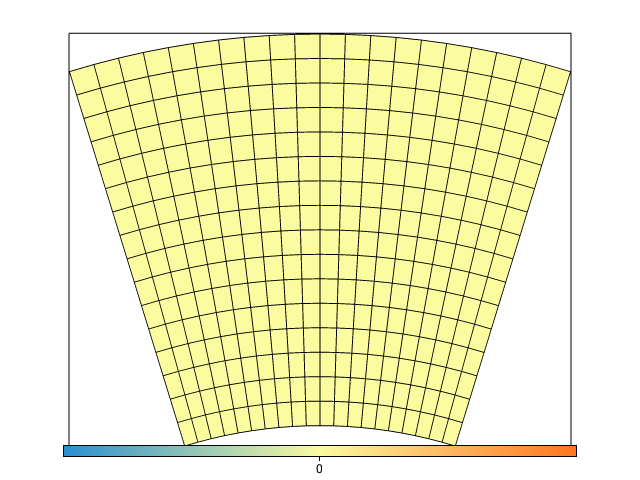


- HandleNaN: ........................................... 0.132319
-- Filter: ............................................. 0.133495
--- Cap_lower=null_upper=null: ......................... 0.137491
---- Operation_uwop=multiply: .......................... 0.140154
----- Normalise: ....................................... 0.145379
------ Component_component=ang: ........................ 0.148659
------- Gradient: ...................................... 0.153398
-------- Projection: ................................... 0.158156
--------- Component_component=rad: ..................... 0.123881
---------- Merge: ...................................... 0.12687
----------- Split_column=0: ............................ 0.090764
------------ Operation_uwop=multiply: .................. 0.077717
------------- Binarise: ................................ 0.071111
-------------- HandleNaN: .............................. 0.071396
--------------- Substitute: ............................ 0.072041
----------

In [4]:
import planetengine
from planetengine import functions as pfn
import numpy as np
from timeit import timeit

system = planetengine.systems.arrhenius.build(res = 128)
initials = {'temperatureField': planetengine.initials.sinusoidal.IC(freq = 1.)}
planetengine.initials.apply(
    initials,
    system,
    )
system.solve()

variable1 = pfn.convert(system.velocityField, 'velocity')
variable2 = pfn.convert(system.temperatureField, 'temperature')
constant = pfn.convert(2.)
shape = pfn.convert(np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]]))
vanilla = pfn.convert(system.viscosityFn, 'viscosity')

def makevar():
    var = variable2
    var = var ** constant
    var = pfn.Region(var, shape)
    var = var * variable1
    var = pfn.Component.rad(var)
    var = pfn.Gradient.mag(var)
    var = pfn.HandleNaN.zero(var)
    var = var + 1.
    var = var * vanilla
    var = pfn.Quantiles.terciles(var)
    var = pfn.Substitute(var, 2., 20.)
    var = pfn.Binarise(var)
    var = var * variable1
    var_a, var_b = pfn.Split.getall(var)
    var_b = var_b ** -1
    var = pfn.Merge(var_a, var_b)
    var = pfn.Component.rad(var)
    var = pfn.Gradient.ang(var)
    var = pfn.Normalise(var, [1., 2.])
    var = pfn.Clip.torange(var, [1.2, 1.8])
    var = pfn.HandleNaN(var, 1.6)
    var = pfn.Filter(var, 1.6)
    var = pfn.Region(var, shape)
    var = pfn.HandleNaN.zero(var)
    var = pfn.Binarise(var)
    return var

print(round(timeit(makevar, number = 3) / 3, 3))

var = makevar()

planetengine.quickShow(var.mesh, var)

def testfn(var, timings = '', layer = 1):
    def outer_timefn(var, timinglist = []):
        planetengine.initials.apply(
            initials,
            system,
            )
        var.update()
        system.iterate()
        timing = timeit(var.update, number = 1)
        timinglist.append(timing)
        return timinglist
    var_timings = []
    for i in range(3):
        var_timings = outer_timefn(var, var_timings)
    var_timing = sum(var_timings) / len(var_timings)
    var_timing = round(var_timing, 6)
    timings += '\n'
    newrow = ''
    newrow += layer * '-' + ' '
    newrow += var.opTag
    newrow += ': '
    newrow += '.' * (56 - len(newrow)) + ' '
    newrow += str(var_timing)
    timings += newrow
    for inVar in var.inVars:
        timings = testfn(inVar, timings, layer + 1)
    return timings

timings = testfn(var)

print(timings)

red = pfn.Integral(var)

planetengine.initials.apply(
    initials,
    system,
    )
red.update()
system.iterate()
print(red.evaluate())
print(red.evaluate())
system.iterate()
print(red.evaluate())
print(red.evaluate())

def testfn():
    freshsteps = []
    stalesteps = []
    for i in range(3):
        planetengine.initials.apply(
            initials,
            system,
            )
        red.update
        system.iterate()
        freshsteps.append(timeit(red.update, number = 1))
    for i in range(3):
        stalesteps.append(timeit(red.update, number = 1))
    average_fresh = round(sum(freshsteps) / len(freshsteps), 5)
    average_stale = round(sum(stalesteps) / len(stalesteps), 5)
    ratio = round(average_fresh / average_stale, 5)
    return(average_fresh, average_stale, ratio)

print(testfn())